<a href="https://colab.research.google.com/github/Mohamed2bdelaziz/NLP/blob/main/CNN_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> [<= Source =>](https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings)


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
import keras
from sklearn.model_selection import train_test_split
import tensorflow
from keras.layers import Embedding
from tensorflow.keras.metrics import F1Score
from sklearn.metrics import confusion_matrix

from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping


In [3]:
# download the dataset, then unzipping it
!kaggle datasets download -d kazanova/sentiment140
!unzip /content/sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training.1600000.processed.noemoticon.csv  


In [4]:
# download the pretrained glove models embeddings
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-04-30 17:33:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.13MB/s    in 2m 39s  

2024-04-30 17:36:15 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [5]:
import pandas as pd

cols = ["target","ids","date","flag","user","text"]
data_df = pd.read_csv(
    "/content/training.1600000.processed.noemoticon.csv",
    names= cols,
    encoding='latin-1')

data_df.shape

(1600000, 6)

In [6]:
# replacing target 4 with 1 in data
data_df.target = data_df.target.replace({4:1})


In [7]:
data_df.target.unique()

array([0, 1])

In [8]:
X = data_df['text'].values
Y = data_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)


In [9]:
X_train.shape, y_test.shape

((1280000,), (320000,))

In [10]:
vectorizer = keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tensorflow.data.Dataset.from_tensor_slices(X_train).batch(64)
vectorizer.adapt(text_ds)

In [11]:
next(iter(text_ds))

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b"@jbtaylor WIth ya. &quot;I'd like a Palm Pre, Touchstone charger. ReadyNow? Yes, that sounds good. But is my beer ready now?'  #prelaunch",
       b'felt the earthquake this afternoon, it seems to be a , but  at the epicenter ',
       b'Ruffles on shirts are like so in, me Likey ',
       b'Pretty bad night into a crappy morning....FML! If only buttface didnt say he could go into work today ',
       b'@dcbriccetti yeah, what a clear view! ',
       b'One more time Follow my fam #FF @georgeann13 @nakithebeatman @flimackgod @chaz81 @djt_elle @jaejaedynomite welcome to Friday Follow me 2 ',
       b'@MsJBell U rock!!! Thanks.  Will be added to next RobCrotch (tm) video. ',
       b"@ssnider yes please! met your fiancee at ian's party the other day, btw... she's very sweet  congrats to you guys!",
       b"My gawd! They've finished the whole bowl before I even posted my previous tweet! Making 2nd bowl ",
       b"@marty_k awesome gam

In [12]:
len(vectorizer.get_vocabulary()), *vectorizer.get_vocabulary()[500:515]

(20000,
 '6',
 'office',
 'boo',
 'dog',
 'course',
 'btw',
 'seeing',
 'started',
 'heart',
 'kind',
 'internet',
 'hehe',
 'using',
 'part',
 'mind')

In [13]:
test_sent = "I love the natural language processing course".lower()
output = vectorizer([[test_sent]])
output.numpy()

array([[   2,   46,    4, 3283, 2538, 7996,  504,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [14]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

[word_index[w] for w in test_sent.split()]

[2, 46, 4, 3283, 2538, 7996, 504]

In [15]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy().astype(np.float64)
X_test = vectorizer(np.array([[s] for s in X_test])).numpy().astype(np.float64)

y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)


In [16]:
X_train.shape, X_train.dtype, y_test.shape, y_test.dtype,

((1280000, 200), dtype('float64'), (320000,), dtype('float32'))

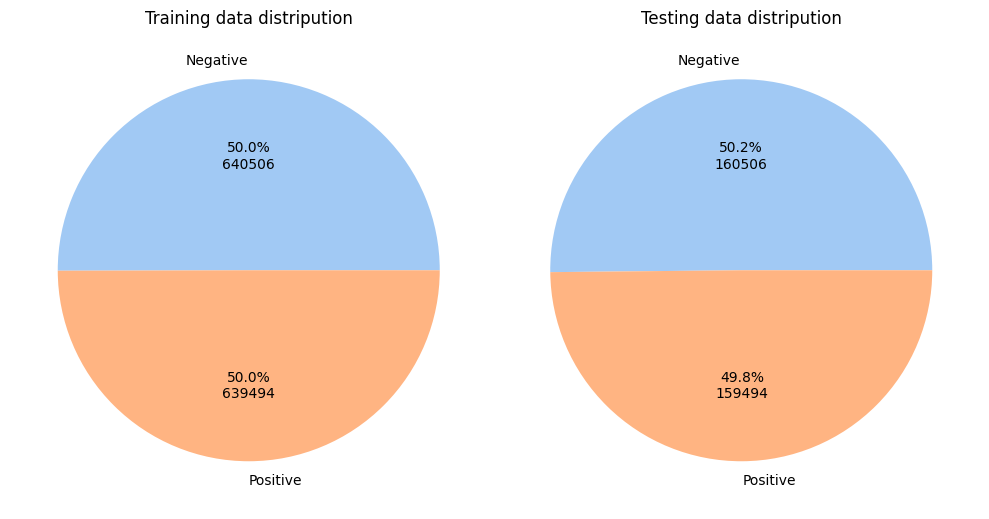

In [17]:
labels = ['Negative', 'Positive']
colors = sns.color_palette("pastel")

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.pie(
    pd.DataFrame(y_train).value_counts(),
    labels=labels,
    colors=colors,
    autopct=lambda x: '{:.1f}%\n{:.0f}'.format(x, len(y_train)*x/100)
)
plt.title('Training data distripution')

plt.subplot(1, 2, 2)
plt.pie(
    pd.DataFrame(y_test).value_counts(),
    labels=labels,
    colors=colors,
    autopct=lambda x: '{:.1f}%\n{:.0f}'.format(x, len(y_test)*x/100)
)
plt.title('Testing data distripution')

plt.tight_layout()
plt.show()

# print(':\n')
# plt.pie(y_train)
# # pd.DataFrame(y_train).plot(kind='pie', subplots=True)
# print('Testing data distripution:\n',pd.DataFrame(y_test).value_counts())

In [18]:
# !gdown 0B7XkCwpI5KDYNlNUTTlSS21pQmM


In [19]:
path_to_glove_file = "glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    print("loading glove embeddings..")
    for line in tqdm(f.readlines()):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


loading glove embeddings..


100%|██████████| 400000/400000 [00:24<00:00, 16101.67it/s]


Found 400000 word vectors.


In [20]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 16302 words (3698 misses)


In [29]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [48]:
def plot_training_val_hist(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  f1 = history.history['f1_score']
  val_f1 = history.history['val_f1_score']
  loss = history.history['loss']
  val_loss = history.history['val_loss']


  # Set up the figure
  plt.figure(figsize=(18, 6))

  # Plot training and validation accuracy
  plt.subplot(1, 3, 1)
  plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
  plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot training and validation f1_score
  plt.subplot(1, 3, 2)
  plt.plot(range(1, len(f1) + 1), f1, label='Training F1_score')
  plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validation F1_score')
  plt.title('Training and Validation F1_score')
  plt.xlabel('Epochs')
  plt.ylabel('F1_score')
  plt.legend()

  # Plot training and validation loss
  plt.subplot(1, 3, 3)
  plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
  plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Customize the style using Seaborn
  sns.set(style='whitegrid')  # You can choose other styles as well

  # Show the plots
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [36]:
def plot_conf_mat(model, X_test = X_test, y_test = y_test):
  idx = np.random.choice(np.arange(len(y_test)), size=50000, replace=False)
  y_pred = model.predict(X_test[idx])
  y_pred = np.where(y_pred > 0.5 , 1, 0)

  conf_mat = confusion_matrix(y_test[idx], y_pred)
  conf_mat = conf_mat.astype(np.float64) / np.sum(conf_mat, axis=1)[:, np.newaxis]

  sns.heatmap(
      conf_mat,
      annot=True,
      fmt='.2%',
      xticklabels = labels,
      yticklabels = labels,
      cmap='Blues')
  plt.title('Test Predictions Confusion Matrix')
  plt.show()

### Testing different CNN model architectures for text classification task.

1. Kim Yoon’s CNN for Sentence Classification

In [37]:
def kim_cnn_model():
    model = tensorflow.keras.Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop", # adam
        metrics=["acc", F1Score()]
    )
    return model

2. Basic CNN for Text Classification

In [38]:
def basic_cnn_model():
    model = tensorflow.keras.Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop", # adam
        metrics=["acc", F1Score()]
    )
    return model

In [39]:
def train_that_model(model, X_train = X_train, y_train = y_train):
  idx = np.random.choice(np.arange(len(y_train)), size=300000, replace=False)
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)
  model_history = model.fit(
      X_train[idx],
      y_train[idx],
      batch_size=128, #64
      epochs=8, #16
      validation_split=0.2,
      callbacks=[early_stopping]
  )
  return model_history

In [40]:
kim_model = kim_cnn_model()
kim_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         6000600   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         115328    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                        

In [41]:
kim_hist = train_that_model(kim_model)

Epoch 1/8
1875/1875 [==============================] - 18s 9ms/step - loss: 0.5002 - acc: 0.7555 - f1_score: 0.6660 - val_loss: 0.4823 - val_acc: 0.7703 - val_f1_score: 0.6658
Epoch 2/8
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4468 - acc: 0.7905 - f1_score: 0.6660 - val_loss: 0.4478 - val_acc: 0.7922 - val_f1_score: 0.6658
Epoch 3/8
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4219 - acc: 0.8040 - f1_score: 0.6660 - val_loss: 0.4493 - val_acc: 0.7929 - val_f1_score: 0.6658
Epoch 4/8
1875/1875 [==============================] - 16s 9ms/step - loss: 0.4019 - acc: 0.8145 - f1_score: 0.6660 - val_loss: 0.4604 - val_acc: 0.7866 - val_f1_score: 0.6658
Epoch 5/8
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3847 - acc: 0.8233 - f1_score: 0.6660 - val_loss: 0.4632 - val_acc: 0.7881 - val_f1_score: 0.6658
Epoch 6/8
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3678 - acc: 0.8314 - f1_score: 0.6660 - va

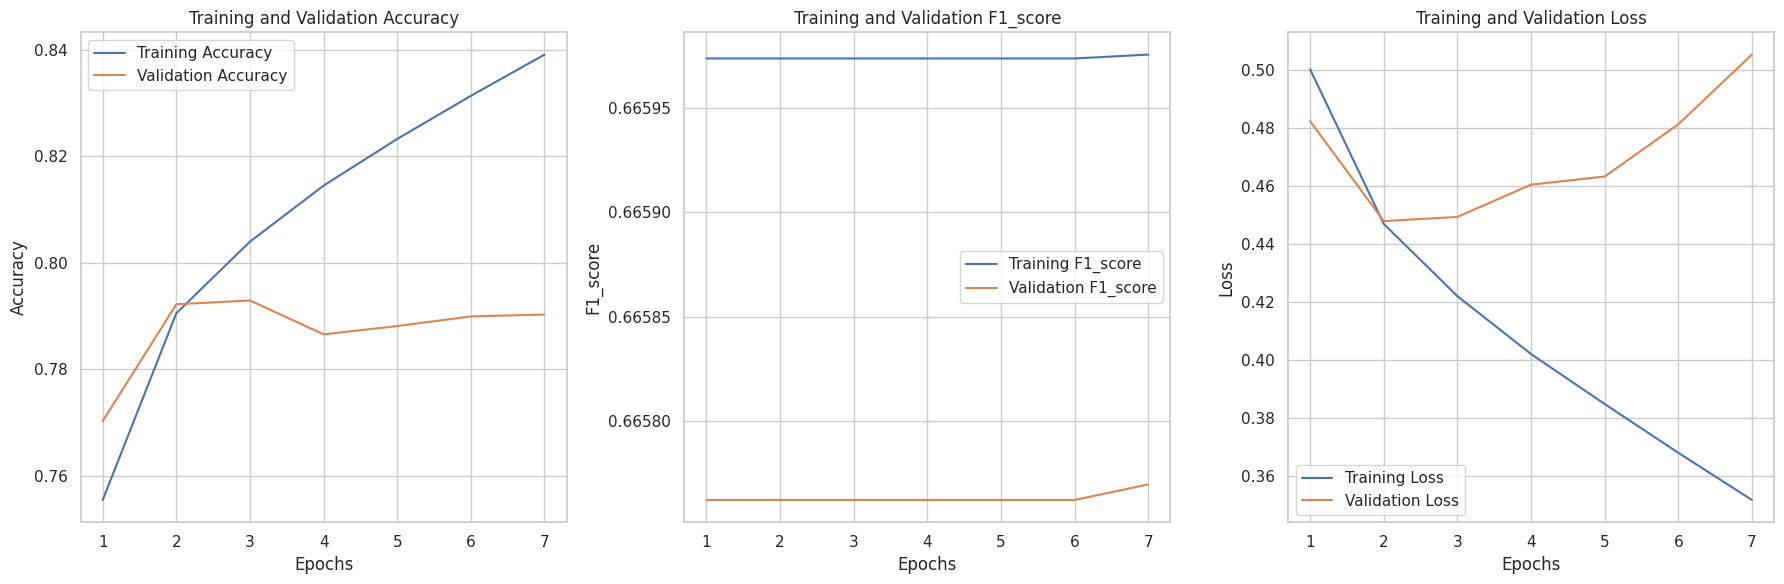

In [49]:
plot_training_val_hist(kim_hist)

1563/1563 [==============================] - 5s 3ms/step


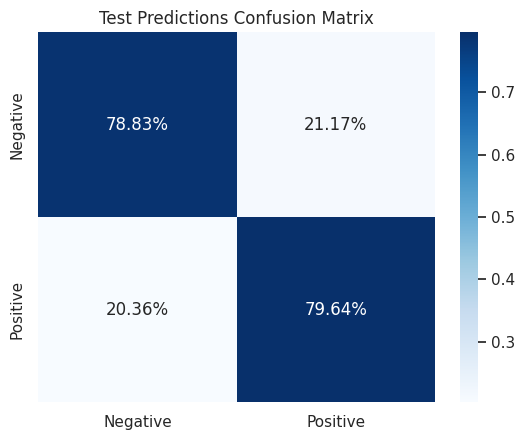

In [43]:
plot_conf_mat(kim_model)

In [44]:
basic_model = basic_cnn_model()
basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         6000600   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          57664     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6062489 (23.13 MB)
Trainable params: 61889 (241.75 KB)
Non-trainable params: 6000600 (22.89 MB)
__________

In [45]:
basic_hist = train_that_model(basic_model)

Epoch 1/8
1875/1875 [==============================] - 17s 7ms/step - loss: 0.4914 - acc: 0.7600 - f1_score: 0.6674 - val_loss: 0.4612 - val_acc: 0.7835 - val_f1_score: 0.6638
Epoch 2/8
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4413 - acc: 0.7927 - f1_score: 0.6674 - val_loss: 0.4518 - val_acc: 0.7887 - val_f1_score: 0.6638
Epoch 3/8
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4198 - acc: 0.8049 - f1_score: 0.6674 - val_loss: 0.4461 - val_acc: 0.7916 - val_f1_score: 0.6638
Epoch 4/8
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4038 - acc: 0.8148 - f1_score: 0.6674 - val_loss: 0.4482 - val_acc: 0.7913 - val_f1_score: 0.6638
Epoch 5/8
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3912 - acc: 0.8212 - f1_score: 0.6674 - val_loss: 0.4515 - val_acc: 0.7921 - val_f1_score: 0.6638
Epoch 6/8
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3797 - acc: 0.8272 - f1_score: 0.6674 - va

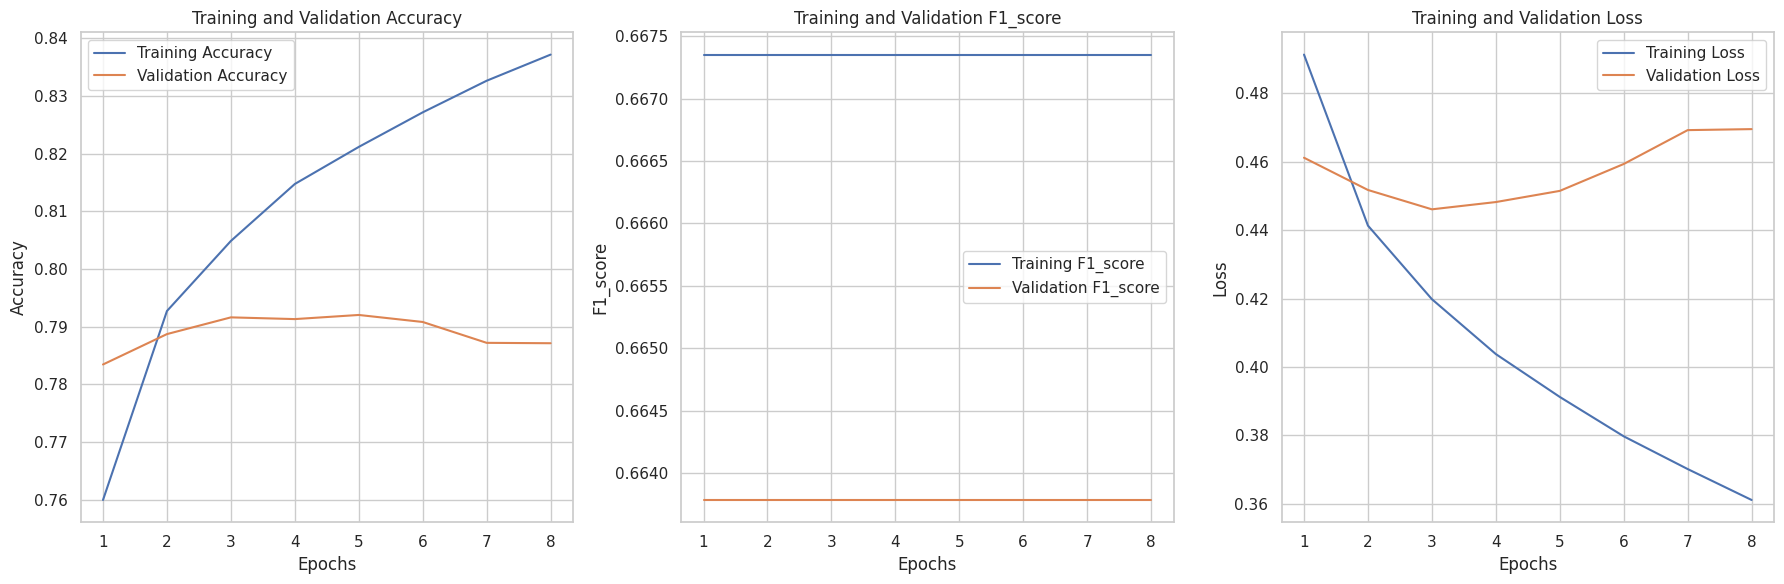

In [50]:
plot_training_val_hist(basic_hist)

1563/1563 [==============================] - 4s 3ms/step


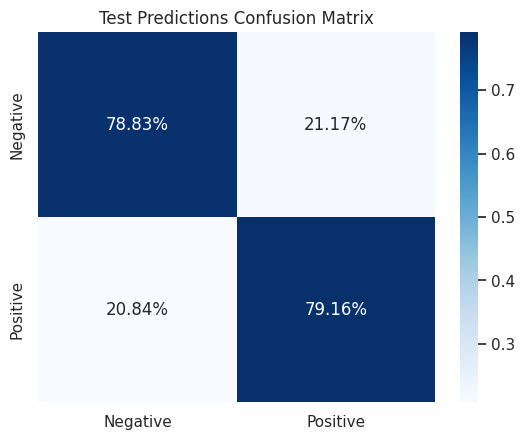

In [47]:
plot_conf_mat(basic_model)

3. Main model

In [21]:


## Arch#1
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = keras.layers.Dropout(0.5)(embedded_sequences) # 0.4
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
preds = keras.layers.Dense(data_df.target.nunique()-1, activation="sigmoid")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

## Arch#2
# vocab_size = 1000
# maxlen = 1000
# batch_size = 128
# embedding_dims = 300
# filters = 16
# kernel_size = 3
# hidden_dims = 250
# epochs = 30

# model = keras.models.Sequential()
# model.add(keras.Input(shape=(None,), dtype="int32"))
# model.add(embedding_layer)
# model.add(Dropout (0.5))
# # model.add(Conv1D (filters, padding='valid',kernel_size,activation= 'relu'))
# model.add(Conv1D(filters, kernel_size, activation='relu', padding='valid'))
# model.add(MaxPooling1D())
# # model.add(Conv1D (filters,padding='valid',kernel_size,activation='relu'))
# model.add(Conv1D(filters, kernel_size, activation='relu', padding='valid'))
# # model.add(MaxPooling1D())
# model.add(keras.layers.GlobalMaxPooling1D())

# model.add(Dense (250, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense (1, activation='sigmoid'))
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         6000600   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                             

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop", # adam
    metrics=["acc", F1Score()]
)

In [23]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128, #64
    epochs=32, #16
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/32
8000/8000 [==============================] - 120s 14ms/step - loss: 0.5000 - acc: 0.7553 - f1_score: 0.6662 - val_loss: 0.4466 - val_acc: 0.7932 - val_f1_score: 0.6666
Epoch 2/32
8000/8000 [==============================] - 101s 13ms/step - loss: 0.4647 - acc: 0.7805 - f1_score: 0.6663 - val_loss: 0.4340 - val_acc: 0.8002 - val_f1_score: 0.6666
Epoch 3/32
8000/8000 [==============================] - 103s 13ms/step - loss: 0.4550 - acc: 0.7868 - f1_score: 0.6663 - val_loss: 0.4310 - val_acc: 0.8002 - val_f1_score: 0.6666
Epoch 4/32
8000/8000 [==============================] - 120s 15ms/step - loss: 0.4498 - acc: 0.7905 - f1_score: 0.6663 - val_loss: 0.4424 - val_acc: 0.7945 - val_f1_score: 0.6671
Epoch 5/32
8000/8000 [==============================] - 129s 16ms/step - loss: 0.4468 - acc: 0.7926 - f1_score: 0.6668 - val_loss: 0.4253 - val_acc: 0.8065 - val_f1_score: 0.6699
Epoch 6/32
8000/8000 [==============================] - 127s 16ms/step - loss: 0.4453 - acc: 0.7941 - f1_

In [24]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 44s 4ms/step - loss: 0.4179 - acc: 0.8092 - f1_score: 0.6681


[0.4178864657878876, 0.809153139591217, array([0.6680708], dtype=float32)]

In [32]:
y_pred = model.predict(X_test)

10000/10000 [==============================] - 26s 3ms/step


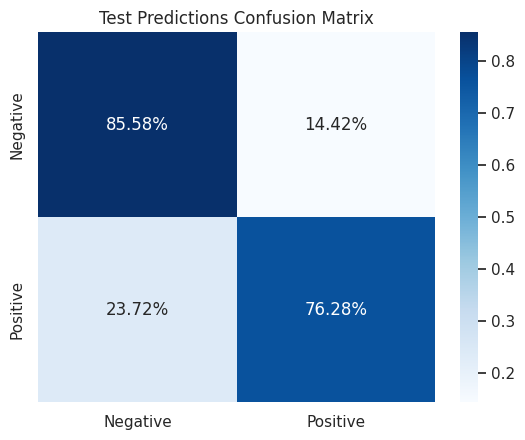

In [33]:
y_pred_ = np.where(y_pred > 0.5 , 1, 0)

conf_mat = confusion_matrix(y_test, y_pred_)
conf_mat = conf_mat.astype(np.float64) / np.sum(conf_mat, axis=1)[:, np.newaxis]

sns.heatmap(
    conf_mat,
    annot=True,
    fmt='.2%',
    xticklabels = labels,
    yticklabels = labels,
    cmap='Blues')
plt.title('Test Predictions Confusion Matrix')
plt.show()

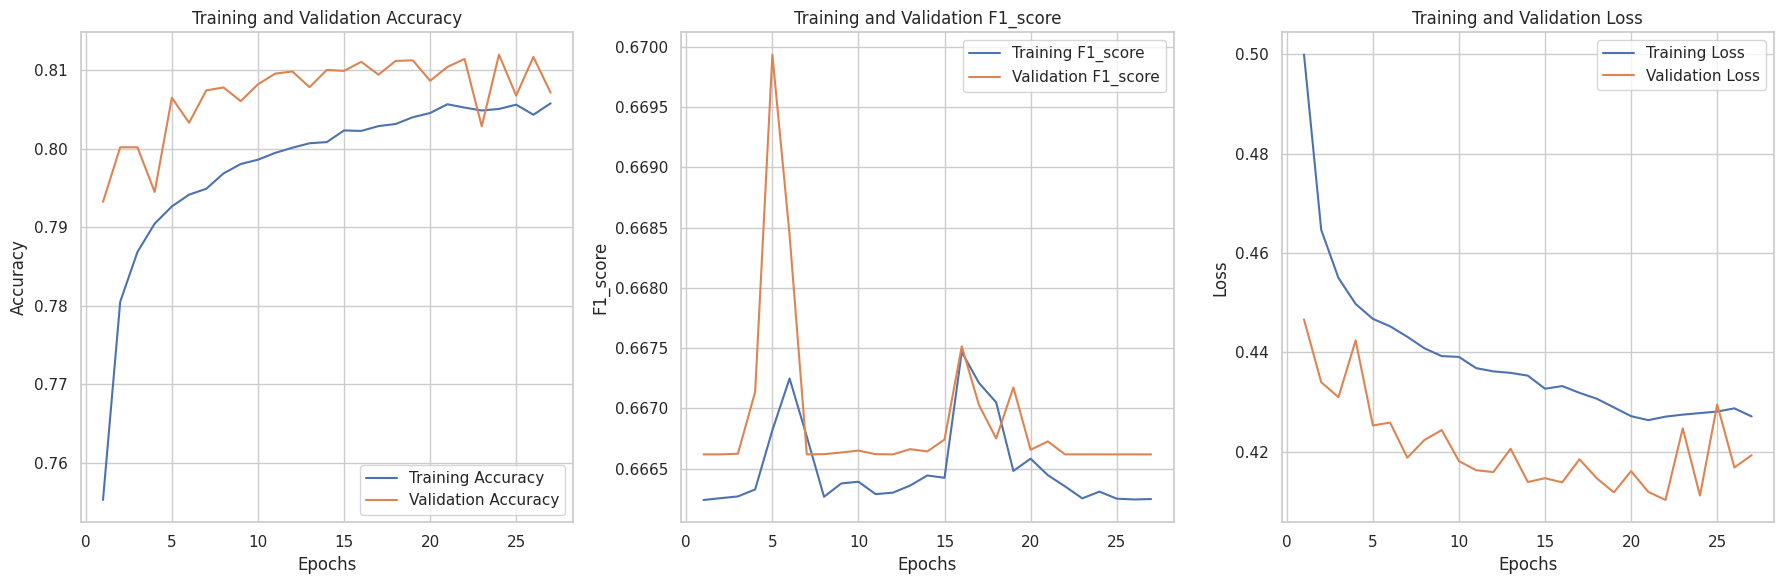

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Set up the figure
plt.figure(figsize=(18, 6))

# Plot training and validation accuracy
plt.subplot(1, 3, 1)
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation f1_score
plt.subplot(1, 3, 2)
plt.plot(range(1, len(f1) + 1), f1, label='Training F1_score')
plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validation F1_score')
plt.title('Training and Validation F1_score')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 3, 3)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Customize the style using Seaborn
sns.set(style='whitegrid')  # You can choose other styles as well

# Show the plots
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# model.save("text_classifier_cnn_model.h5")